In [75]:
import os
import sys
import geopandas as gpd  # type: ignore
import sqlalchemy as sq
from matplotlib import pyplot as plt  # type: ignore
import matplotlib.patches as mpatches  # type: ignore
from dotenv import load_dotenv

sys.path.append("../")
from Shared.DataService import DataService

In [76]:
MB_CUTOFF_ELEVATION = 300 + 50  # the average elevation for MB in m plus a 50m buffer
SK_CUTOFF_ELEVATION = 610 + 50  # the average elevation for SK in m plus a 50m buffer
AB_CUTOFF_ELEVATION = 800 + 50  # the average elevation for AB in m plus a 50m buffer

load_dotenv()
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")

In [77]:
if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    raise ValueError("Environment variables not set")

# Handles connections to the database
db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
conn = db.connect()

In [78]:
regionQuery = sq.text("select car_uid, color, geometry FROM public.census_ag_regions")
agRegions = gpd.GeoDataFrame.from_postgis(
    regionQuery, conn, crs="EPSG:3347", geom_col="geometry"
)

In [79]:
allDlyQuery = sq.text("SELECT * FROM public.stations_dly")
dlyQuery = sq.text(
    f"""
    SELECT latitude, longitude, MIN(dly_first_year), MAX(dly_last_year), district, geometry FROM public.stations_dly 
    WHERE dly_first_year IS NOT NULL AND dly_last_year IS NOT NULL AND
        (elevation <= {MB_CUTOFF_ELEVATION} AND province = 'MB' OR elevation <= {SK_CUTOFF_ELEVATION} AND province = 'SK' OR elevation <= {AB_CUTOFF_ELEVATION} AND province = 'AB')
    GROUP BY latitude, longitude, district, geometry;
    """
)

allDlyStations = gpd.GeoDataFrame.from_postgis(
    allDlyQuery, conn, crs="EPSG:3347", geom_col="geometry"
)
dlyStations = gpd.GeoDataFrame.from_postgis(
    dlyQuery, conn, crs="EPSG:3347", geom_col="geometry"
)

In [80]:
allHlyQuery = sq.text("SELECT * FROM public.stations_hly")
hlyQuery = sq.text(
    f"""
    SELECT latitude, longitude, MIN(dly_first_year), MAX(dly_last_year), district, geometry FROM public.stations_hly 
    WHERE hly_first_year IS NOT NULL AND hly_last_year IS NOT NULL AND
        (elevation <= {MB_CUTOFF_ELEVATION} AND province = 'MB' OR elevation <= {SK_CUTOFF_ELEVATION} AND province = 'SK' OR elevation <= {AB_CUTOFF_ELEVATION} AND province = 'AB')
    GROUP BY latitude, longitude, district, geometry;
    """
)

allHlyStations = gpd.GeoDataFrame.from_postgis(
    allHlyQuery, conn, crs="EPSG:3347", geom_col="geometry"
)
hlyStations = gpd.GeoDataFrame.from_postgis(
    hlyQuery, conn, crs="EPSG:3347", geom_col="geometry"
)

In [81]:
db.cleanup()

In [82]:
agRegions.loc[agRegions["car_uid"] == 4612, "color"] = "white"

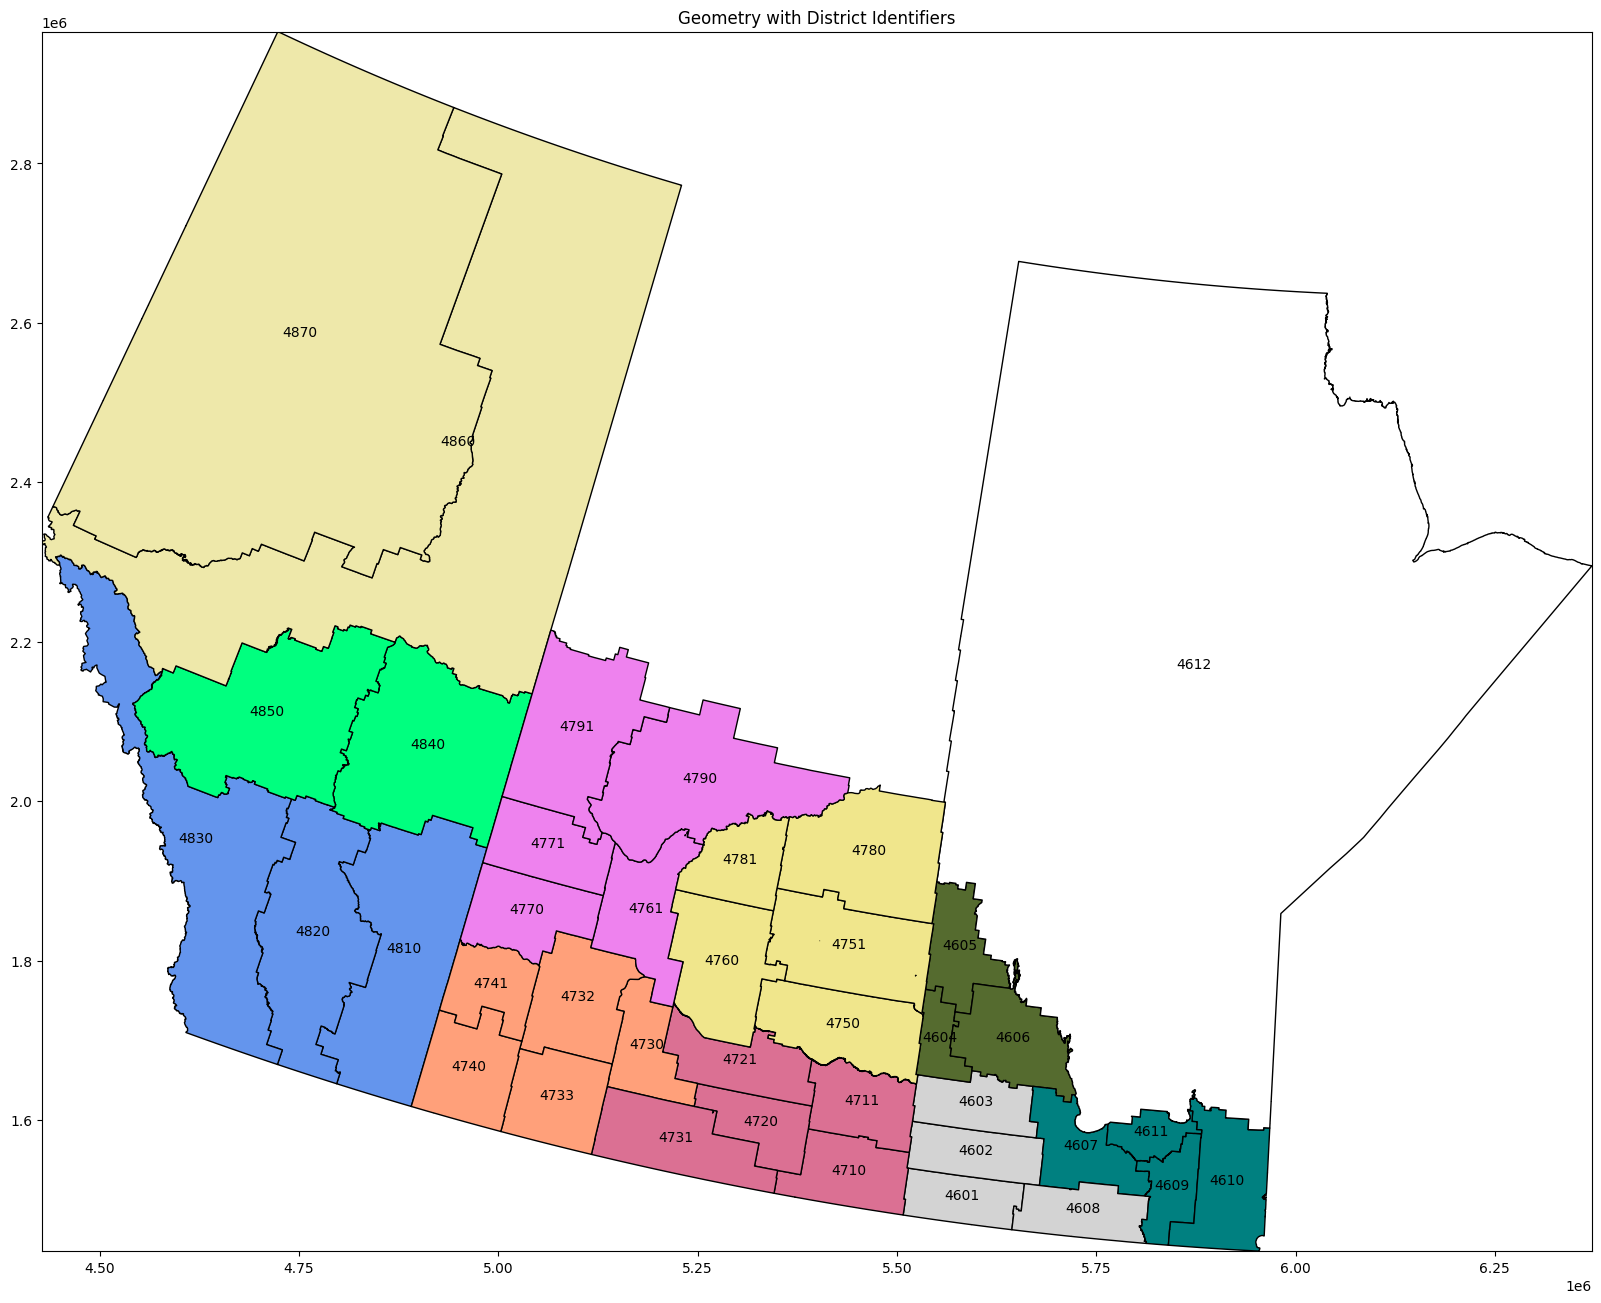

In [83]:
minx, miny, maxx, maxy = agRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("Geometry with District Identifiers")
agRegions.plot(ax=ax, color=agRegions["color"], edgecolor="black")
agRegions.apply(
    lambda x: ax.annotate(
        text=x["car_uid"],
        xy=x.geometry.centroid.coords[0],
        ha="center",
        color="black",
        size=10,
    ),
    axis=1,
)
plt.show()

In [84]:
hourly = mpatches.Patch(color="black", label="Houly stations (larger)")
daily = mpatches.Patch(color="red", label="Daily stations (smaller)")
stations = mpatches.Patch(color="red", label="Stations")

hasLessThan5Col = "white"
hasLessThan10Col = "pink"
hasLessThan15Col = "red"
hasLessThan20Col = "maroon"
hasMoreThan20Col = "black"

hasLessThan5Yrs = mpatches.Patch(
    color=hasLessThan5Col, label="Less than 5 years of data"
)
hasLessThan10Yrs = mpatches.Patch(
    color=hasLessThan10Col, label="Less than 10 years of data"
)
hasLessThan15Yrs = mpatches.Patch(
    color=hasLessThan15Col, label="Less than 15 years of data"
)
hasLessThan20Yrs = mpatches.Patch(
    color=hasLessThan20Col, label="Less than 20 years of data"
)
hasMoreThan20Yrs = mpatches.Patch(
    color=hasMoreThan20Col, label="More than 20 years of data"
)

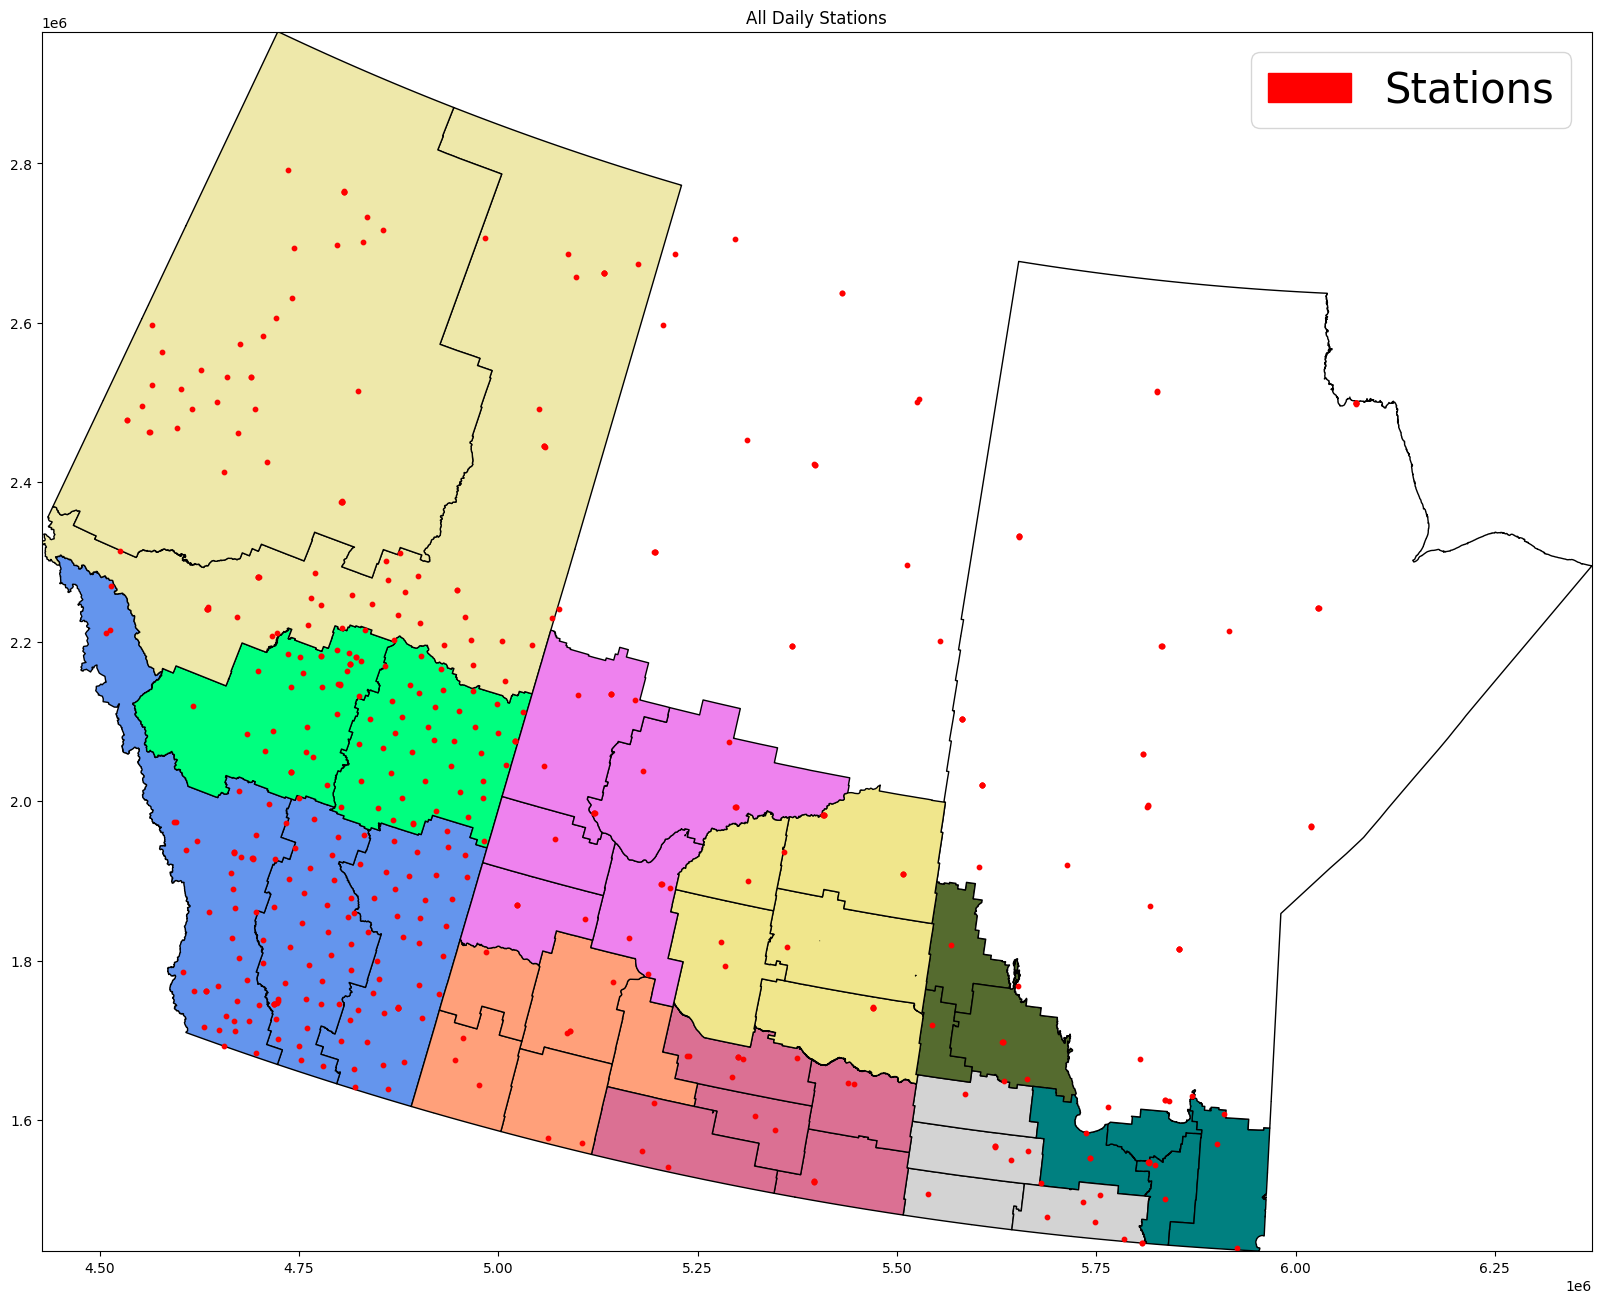

In [85]:
minx, miny, maxx, maxy = agRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("All Daily Stations")
agRegions.plot(ax=ax, color=agRegions["color"], edgecolor="black")
allDlyStations.plot(ax=ax, color="red", markersize=10)
plt.legend(handles=[stations], fontsize="30")

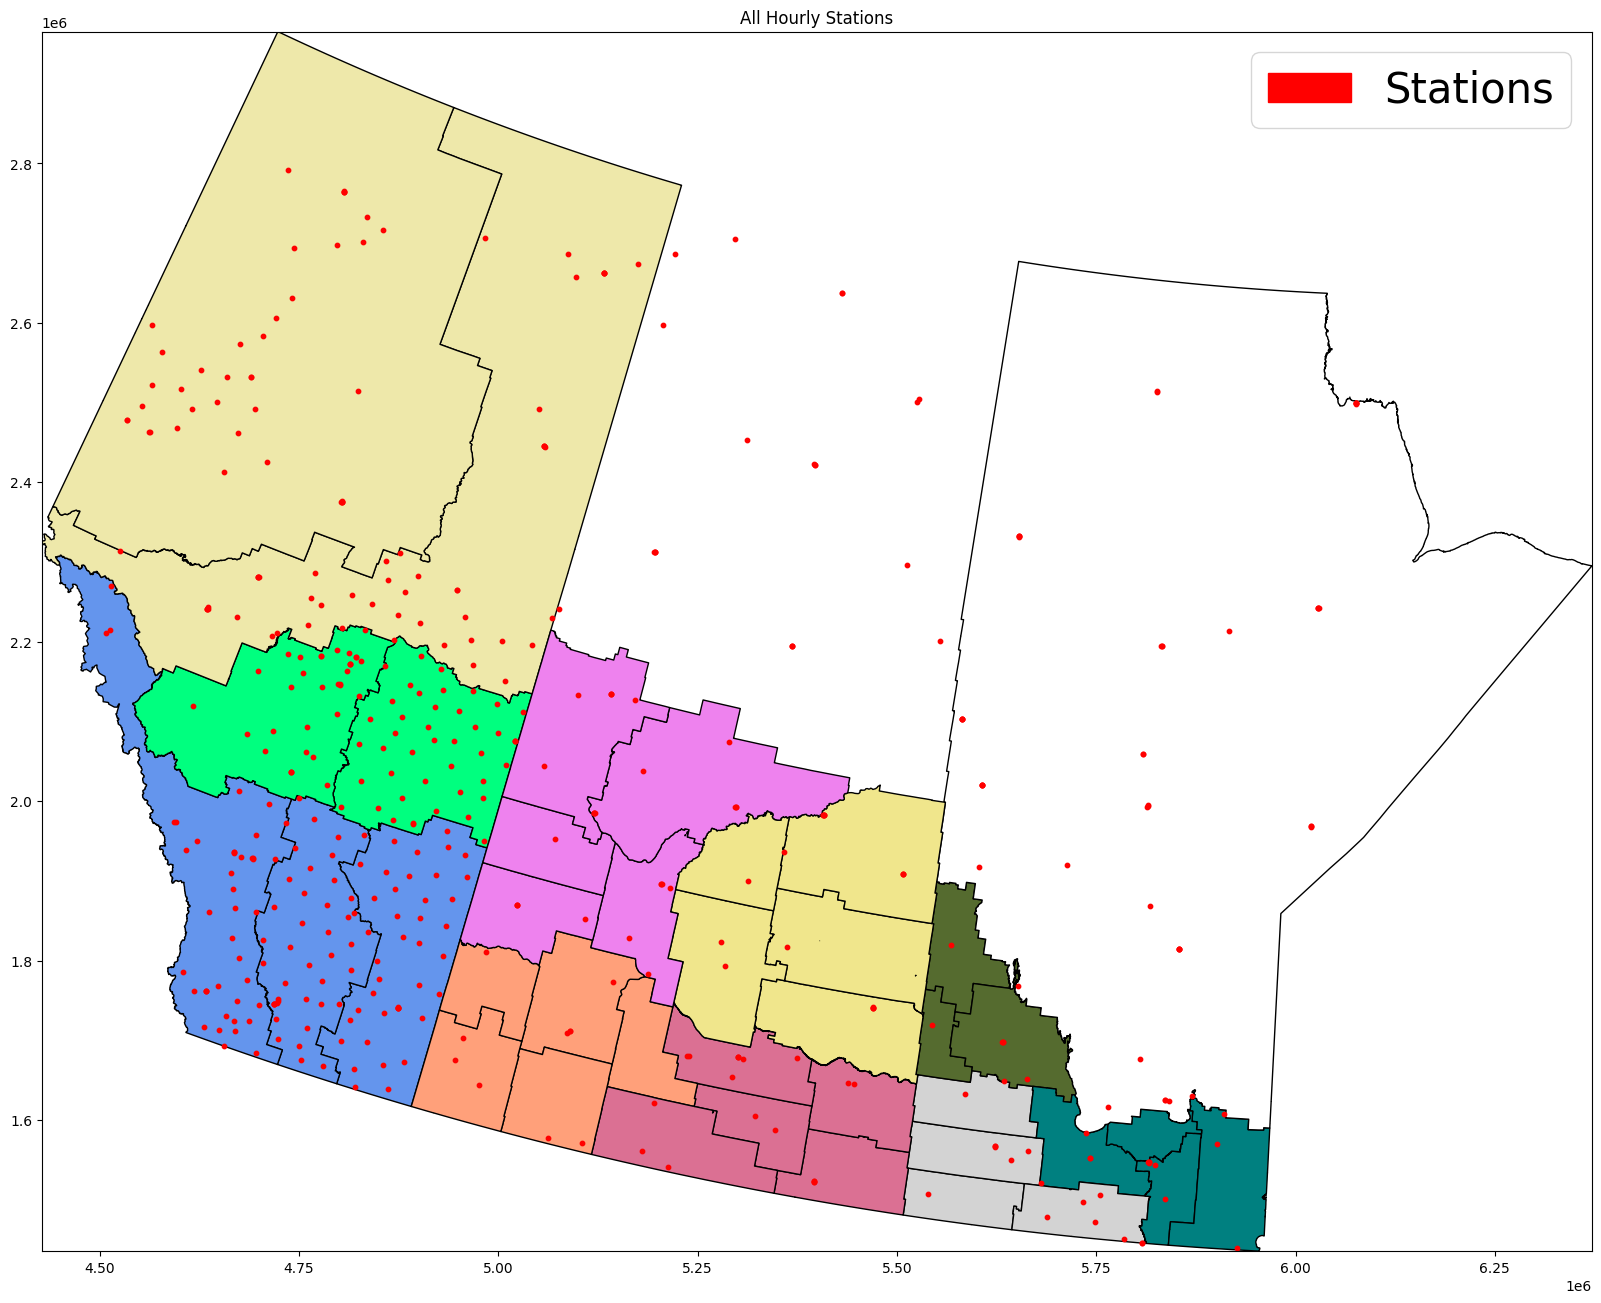

In [86]:
minx, miny, maxx, maxy = agRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("All Hourly Stations")
agRegions.plot(ax=ax, color=agRegions["color"], edgecolor="black")
allHlyStations.plot(ax=ax, color="red", markersize=10)
plt.legend(handles=[stations], fontsize="30")

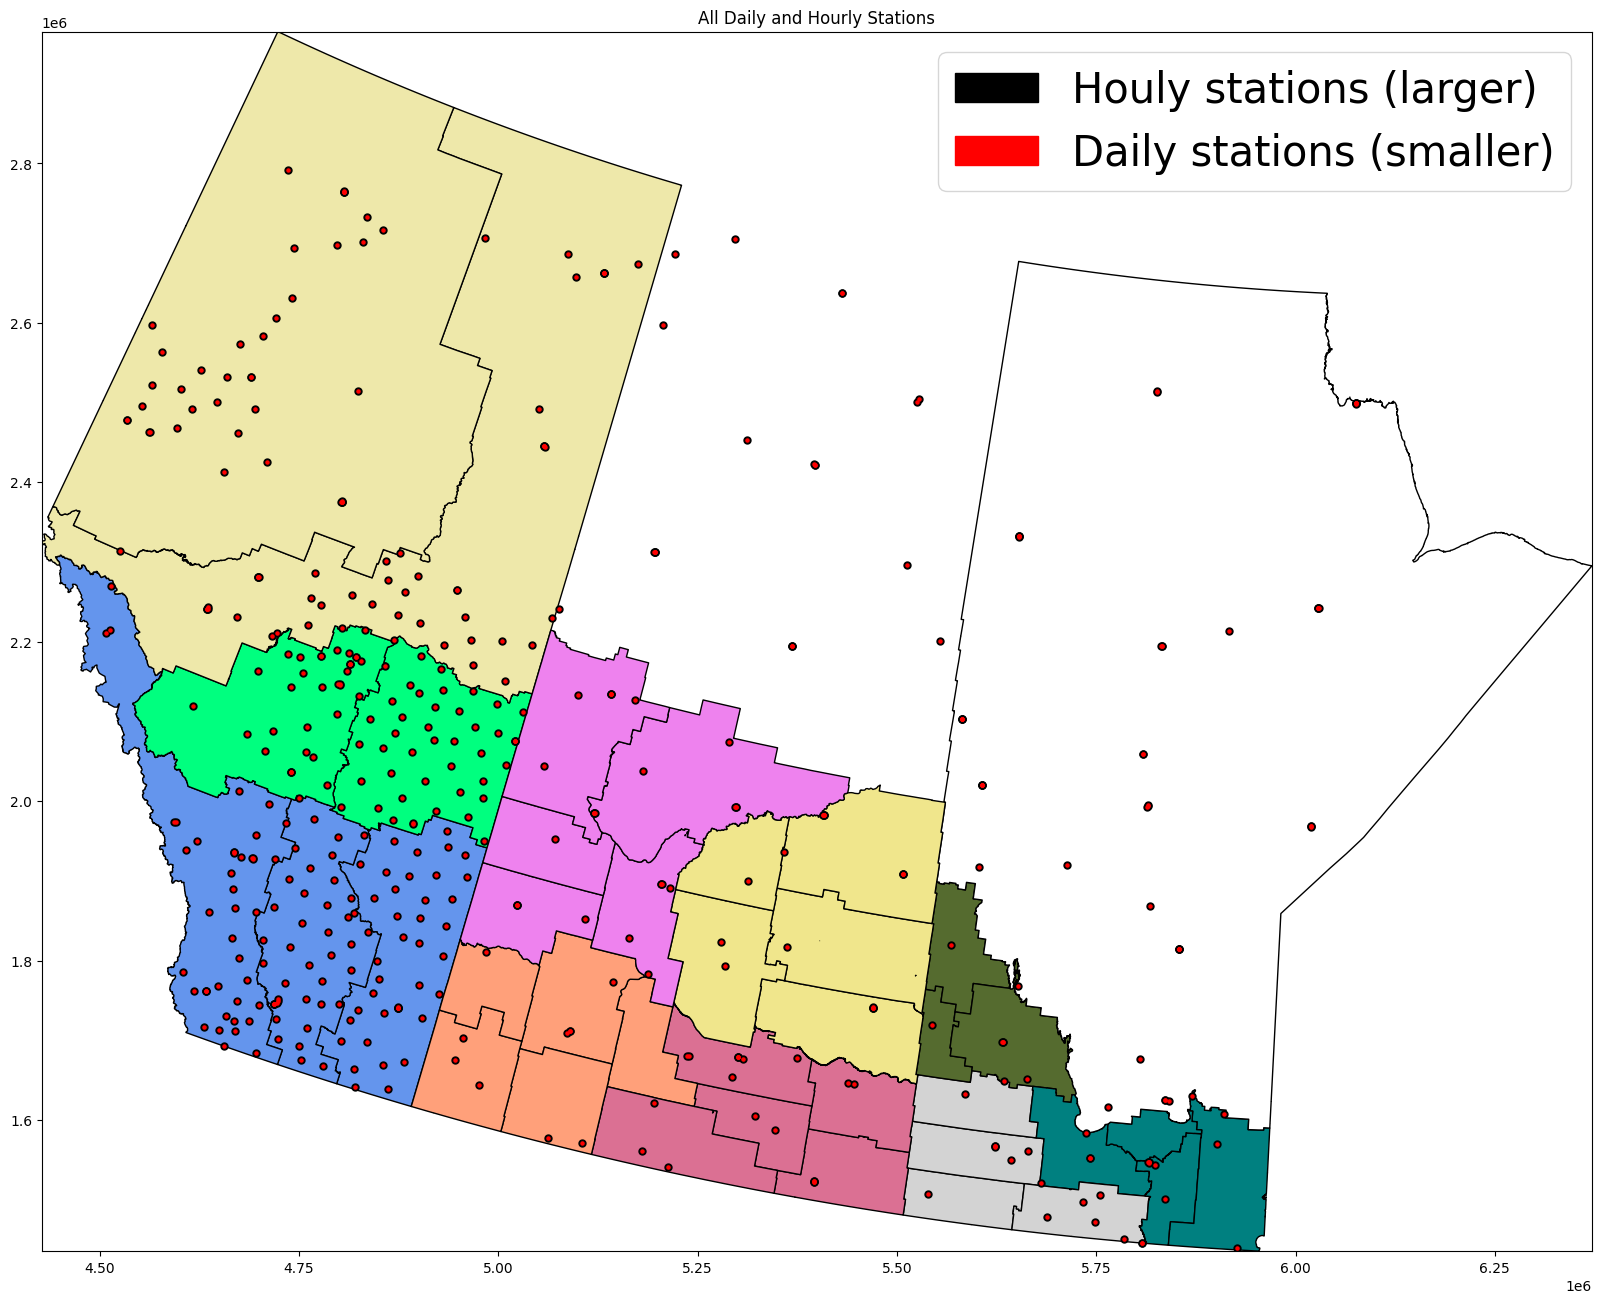

In [87]:
minx, miny, maxx, maxy = agRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("All Daily and Hourly Stations")
agRegions.plot(ax=ax, color=agRegions["color"], edgecolor="black")
allHlyStations.plot(ax=ax, color="black", markersize=25)
allDlyStations.plot(ax=ax, color="red", markersize=5)
plt.legend(handles=[hourly, daily], fontsize="30")

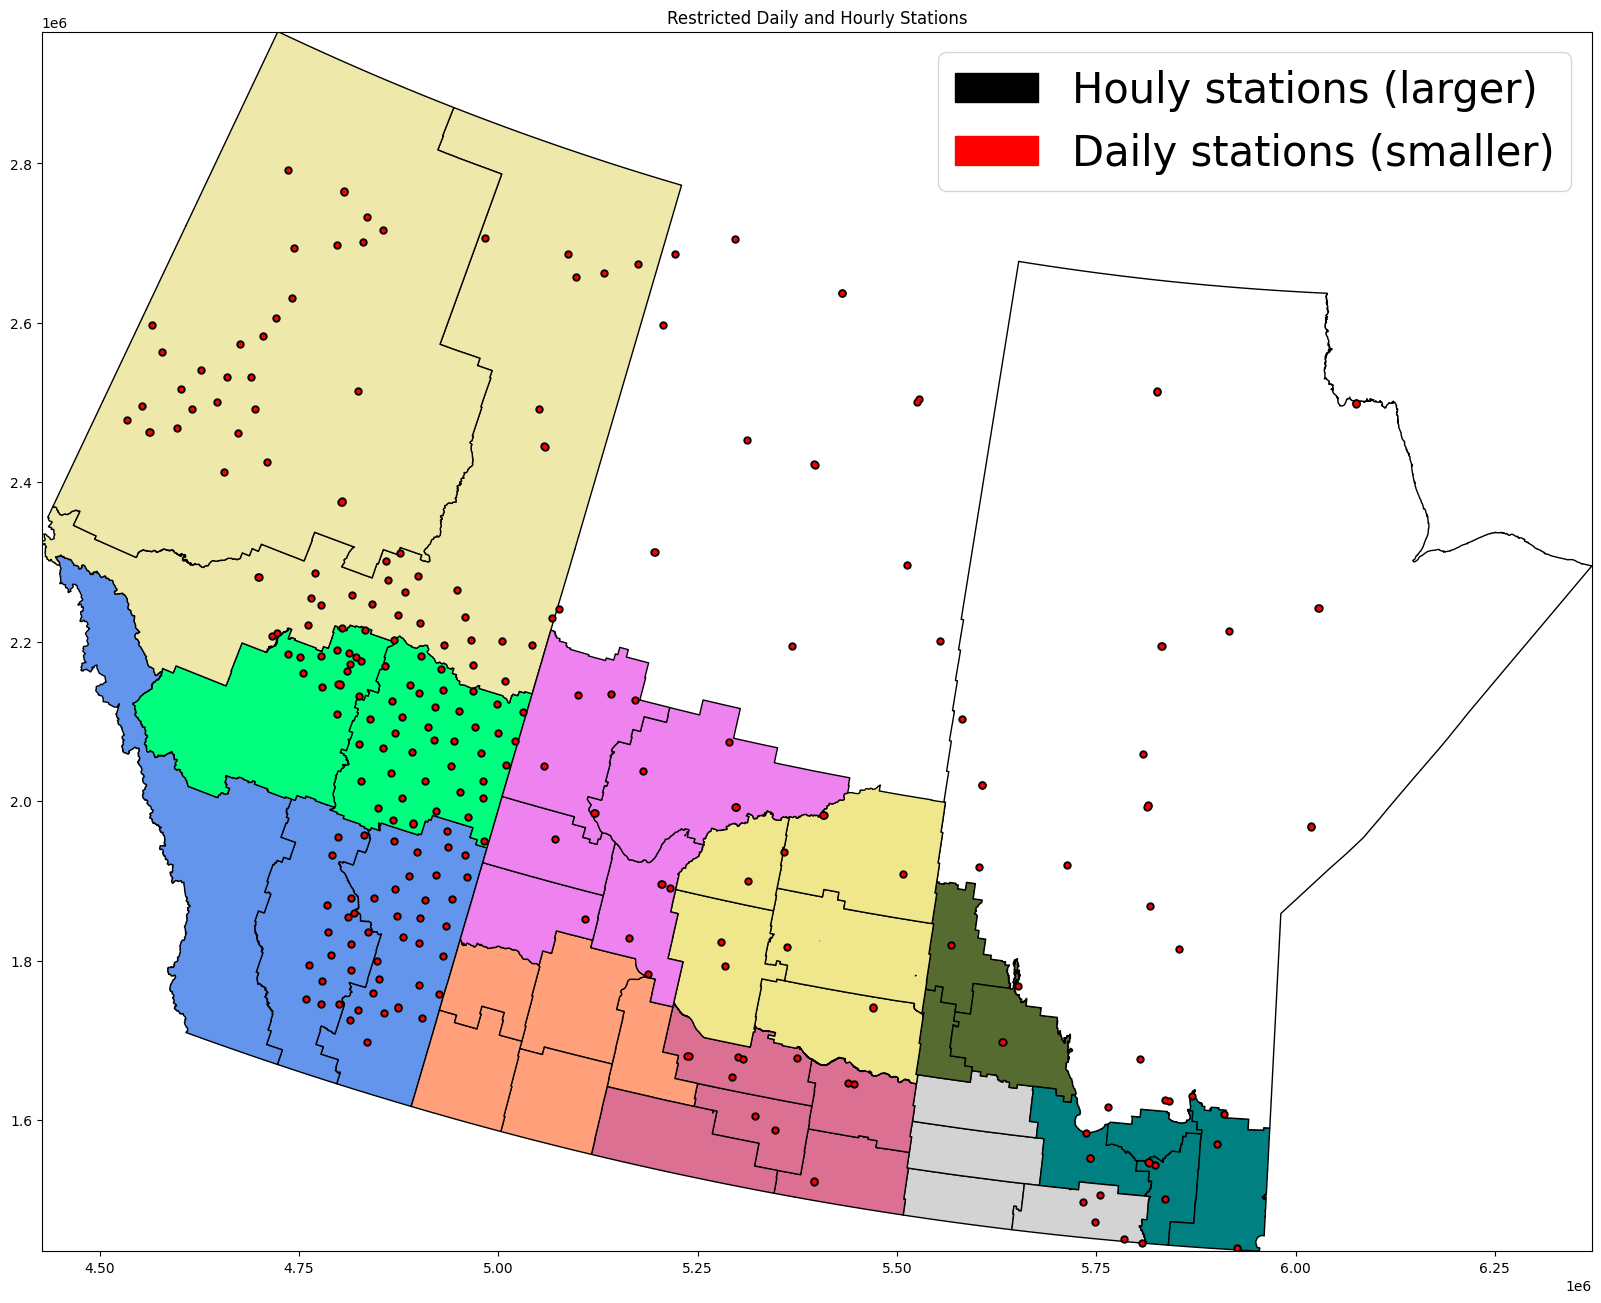

In [88]:
minx, miny, maxx, maxy = agRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("Restricted Daily and Hourly Stations")
agRegions.plot(ax=ax, color=agRegions["color"], edgecolor="black")
dlyStations.plot(ax=ax, color="black", markersize=25)
hlyStations.plot(ax=ax, color="red", markersize=5)
plt.legend(handles=[hourly, daily], fontsize="30")

In [89]:
activeDlyStations = gpd.GeoDataFrame(
    dlyStations.drop(dlyStations[dlyStations["max"] != 2022].index)
)
activeHlyStations = gpd.GeoDataFrame(
    hlyStations.drop(hlyStations[hlyStations["max"] != 2022].index)
)

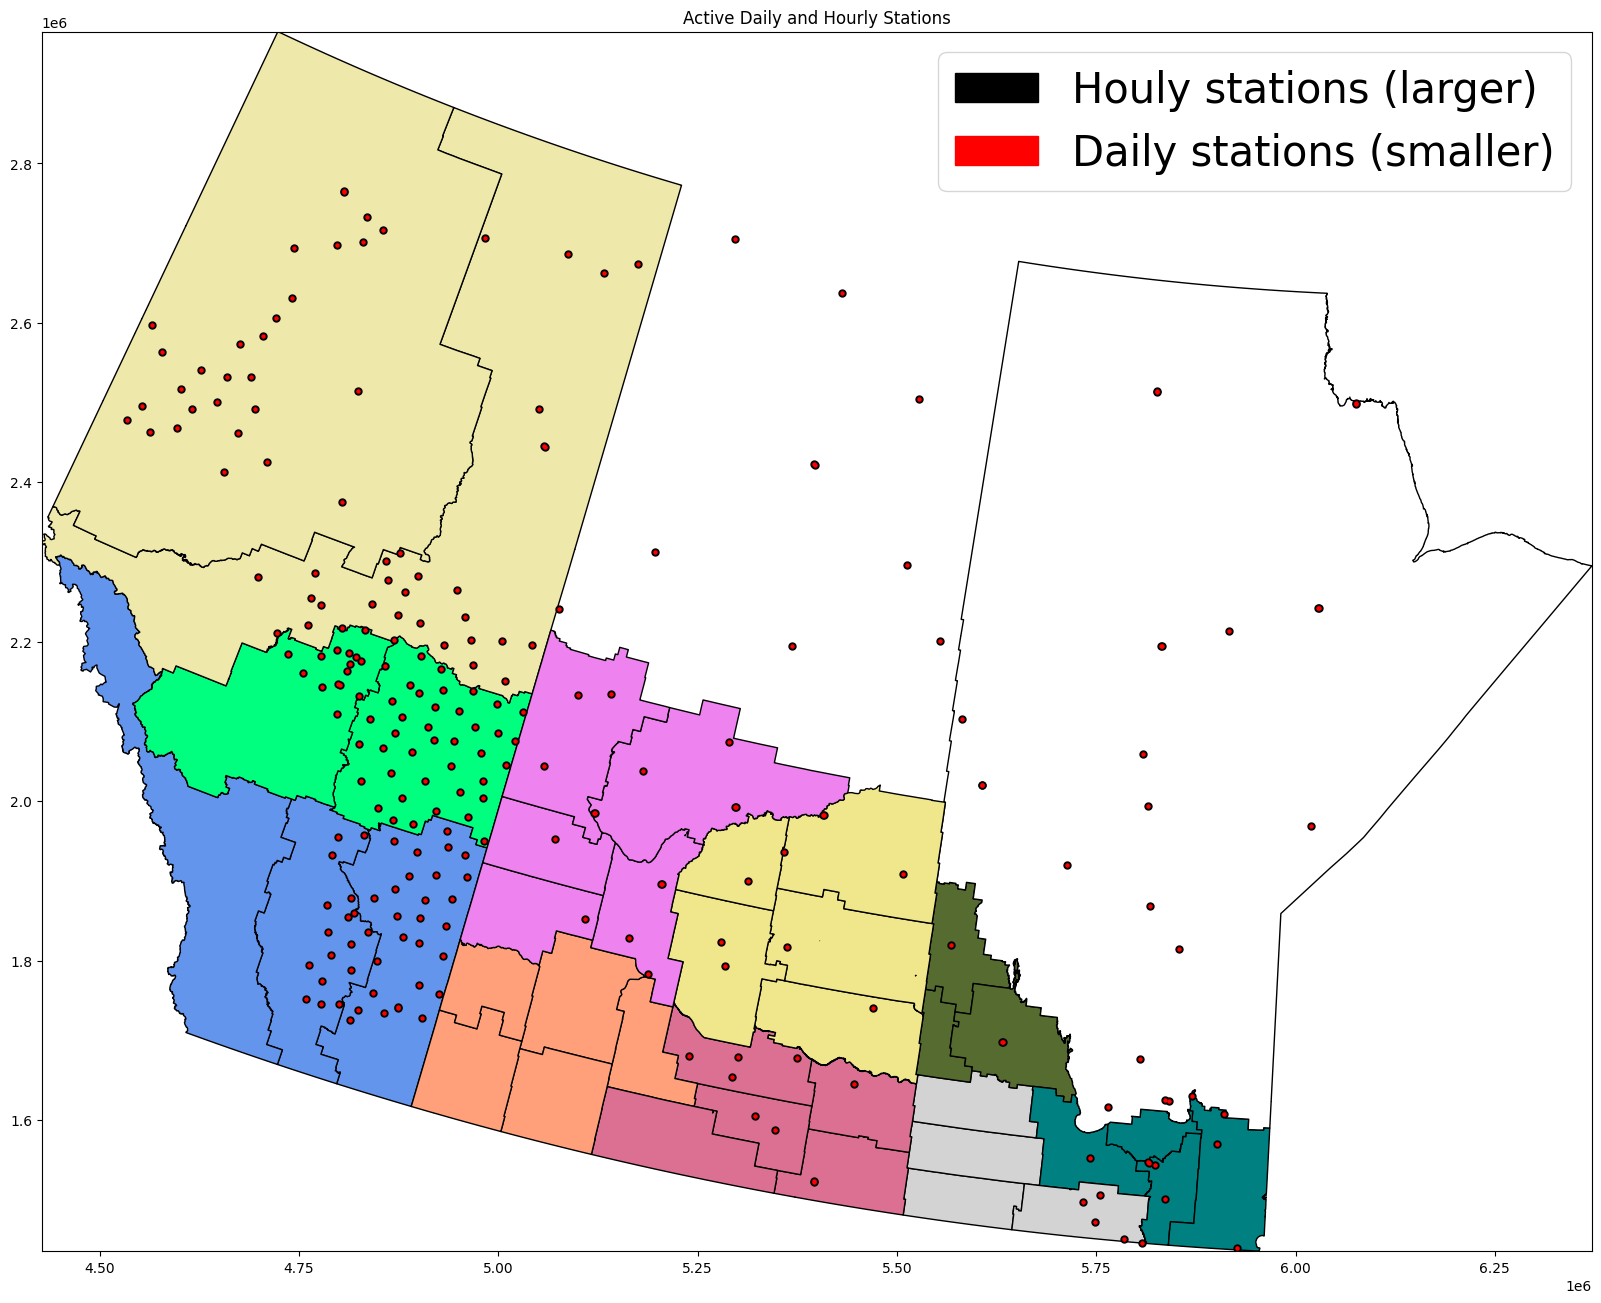

In [90]:
minx, miny, maxx, maxy = agRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("Active Daily and Hourly Stations")
agRegions.plot(ax=ax, color=agRegions["color"], edgecolor="black", label=5)
activeHlyStations.plot(ax=ax, color="black", markersize=25)
activeDlyStations.plot(ax=ax, color="red", markersize=5)

plt.legend(handles=[hourly, daily], fontsize="30")

In [91]:
coloredDlyStations = gpd.GeoDataFrame(dlyStations)
coloredHlyStations = gpd.GeoDataFrame(hlyStations)

coloredDlyStations["color"] = None
coloredHlyStations["color"] = None

In [92]:
def checkColor(df, index, firstYear, lastYear):
    numYrs = lastYear - firstYear

    if numYrs <= 5:
        df.at[index, "color"] = hasLessThan5Col
    elif numYrs <= 10:
        df.at[index, "color"] = hasLessThan10Col
    elif numYrs <= 15:
        df.at[index, "color"] = hasLessThan15Col
    elif numYrs <= 20:
        df.at[index, "color"] = hasLessThan20Col
    else:
        df.at[index, "color"] = hasMoreThan20Col

In [93]:
for index, row in coloredDlyStations.iterrows():
    checkColor(coloredDlyStations, index, row["min"], row["max"])

for index, row in coloredHlyStations.iterrows():
    checkColor(coloredHlyStations, index, row["min"], row["max"])

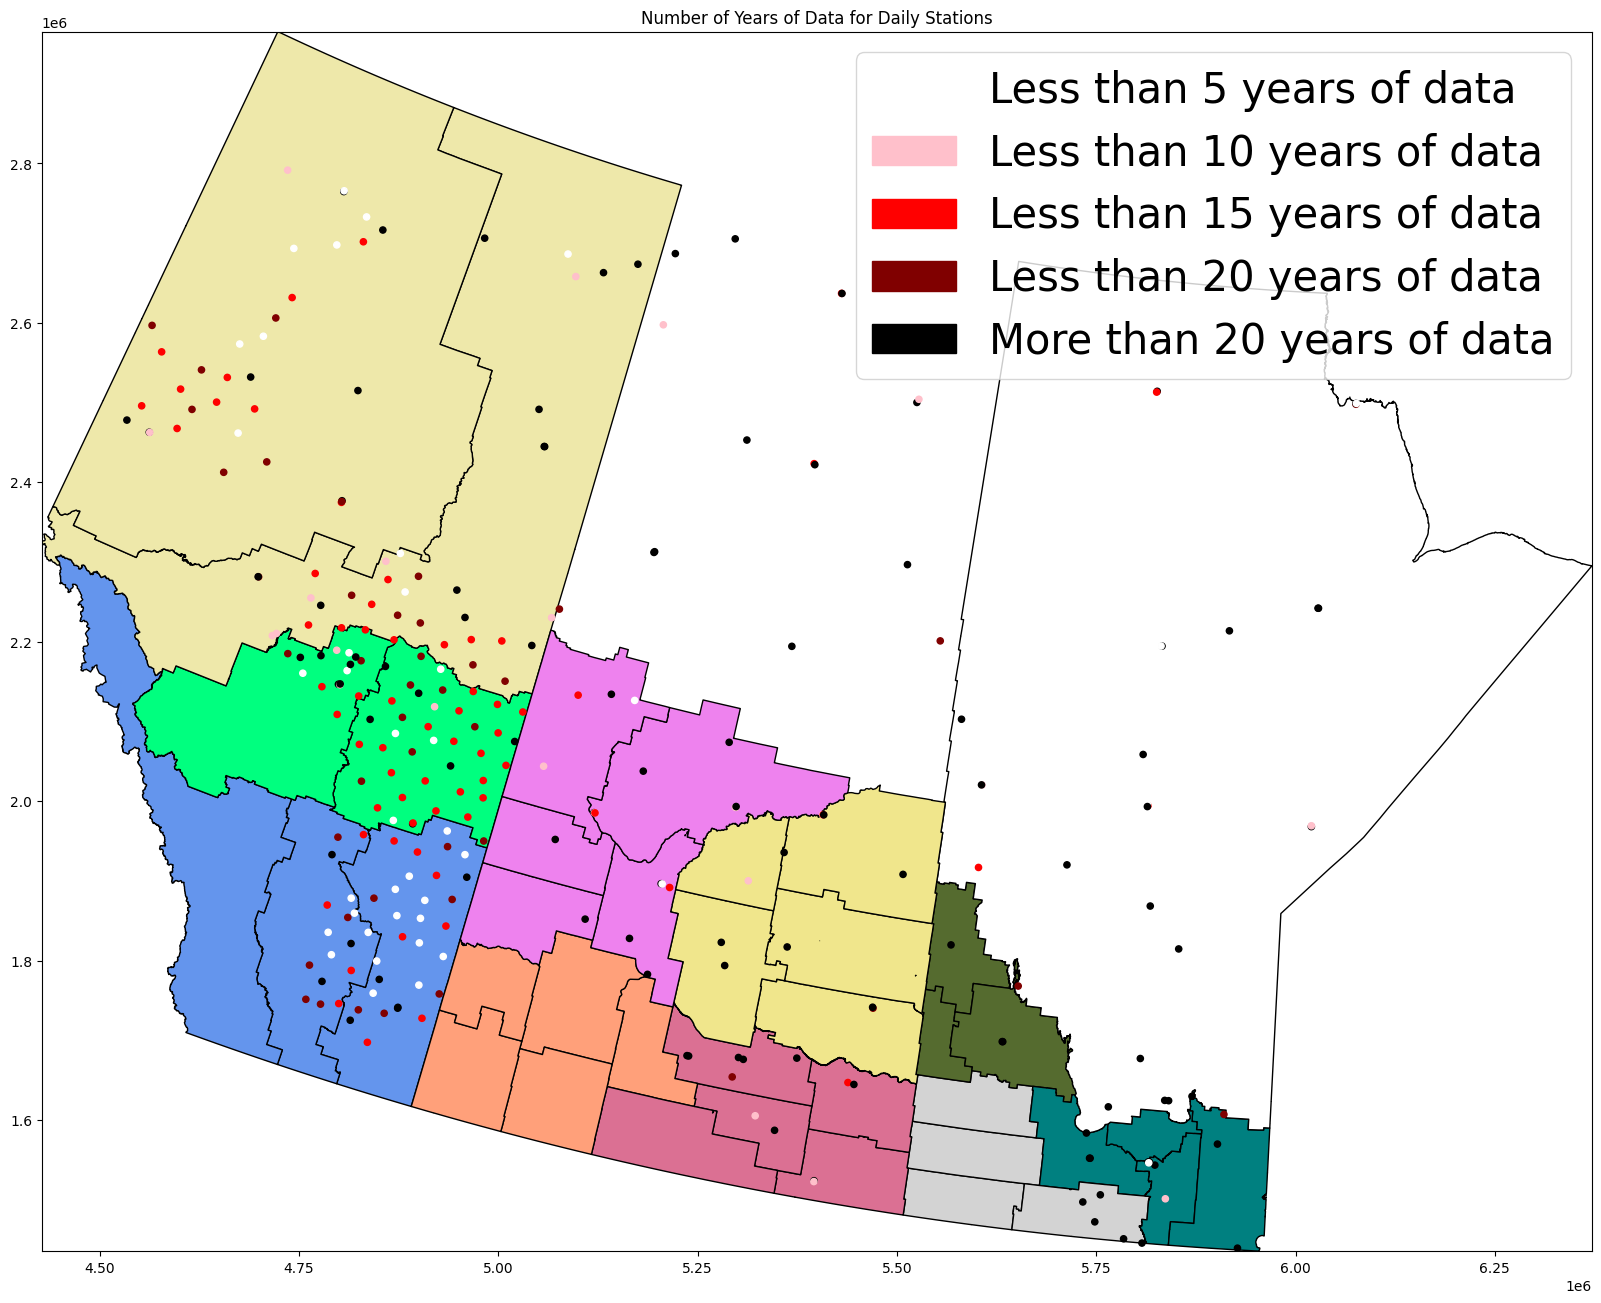

In [94]:
minx, miny, maxx, maxy = agRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("Number of Years of Data for Daily Stations")
agRegions.plot(ax=ax, color=agRegions["color"], edgecolor="black")
coloredDlyStations.plot(ax=ax, color=coloredDlyStations["color"], markersize=20)
plt.legend(
    handles=[
        hasLessThan5Yrs,
        hasLessThan10Yrs,
        hasLessThan15Yrs,
        hasLessThan20Yrs,
        hasMoreThan20Yrs,
    ],
    fontsize="30",
)

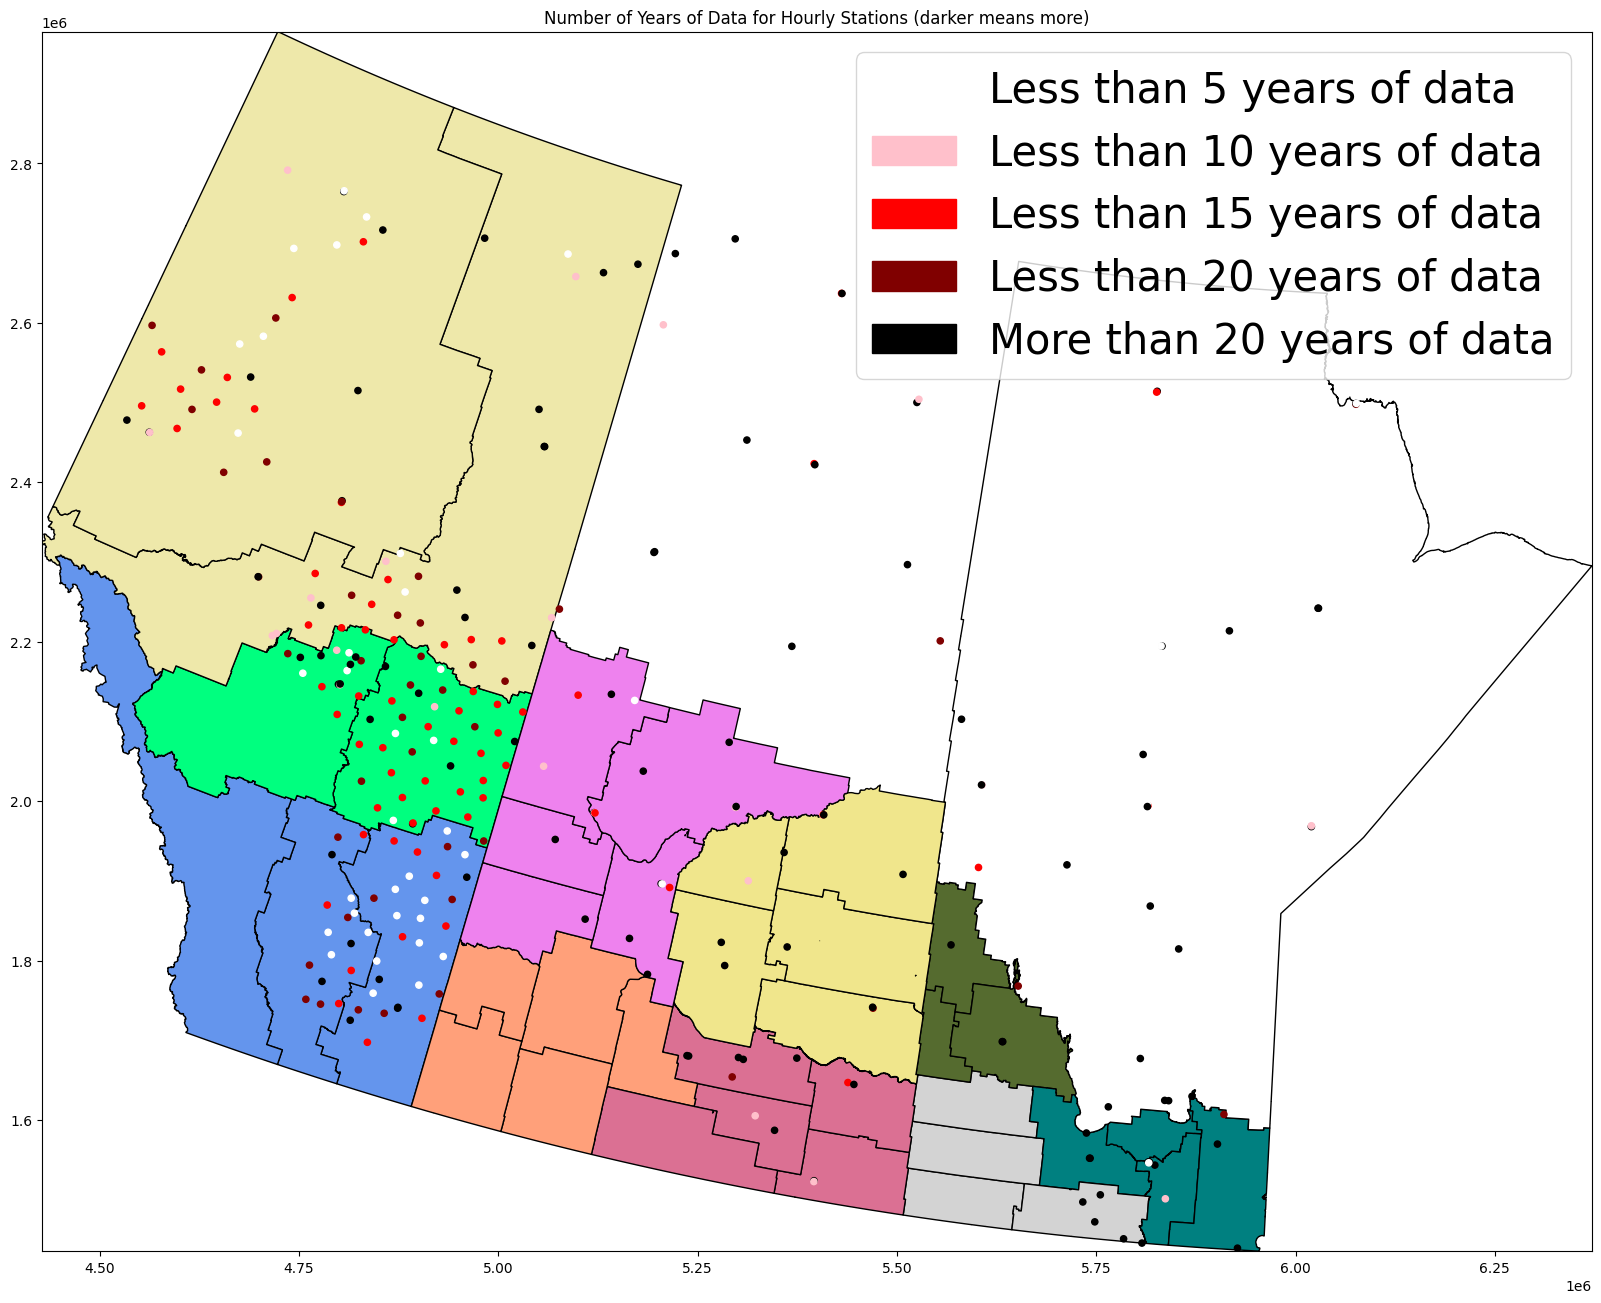

In [95]:
minx, miny, maxx, maxy = agRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("Number of Years of Data for Hourly Stations (darker means more)")
agRegions.plot(ax=ax, color=agRegions["color"], edgecolor="black")
coloredHlyStations.plot(ax=ax, color=coloredHlyStations["color"], markersize=20)
plt.legend(
    handles=[
        hasLessThan5Yrs,
        hasLessThan10Yrs,
        hasLessThan15Yrs,
        hasLessThan20Yrs,
        hasMoreThan20Yrs,
    ],
    fontsize="30",
)

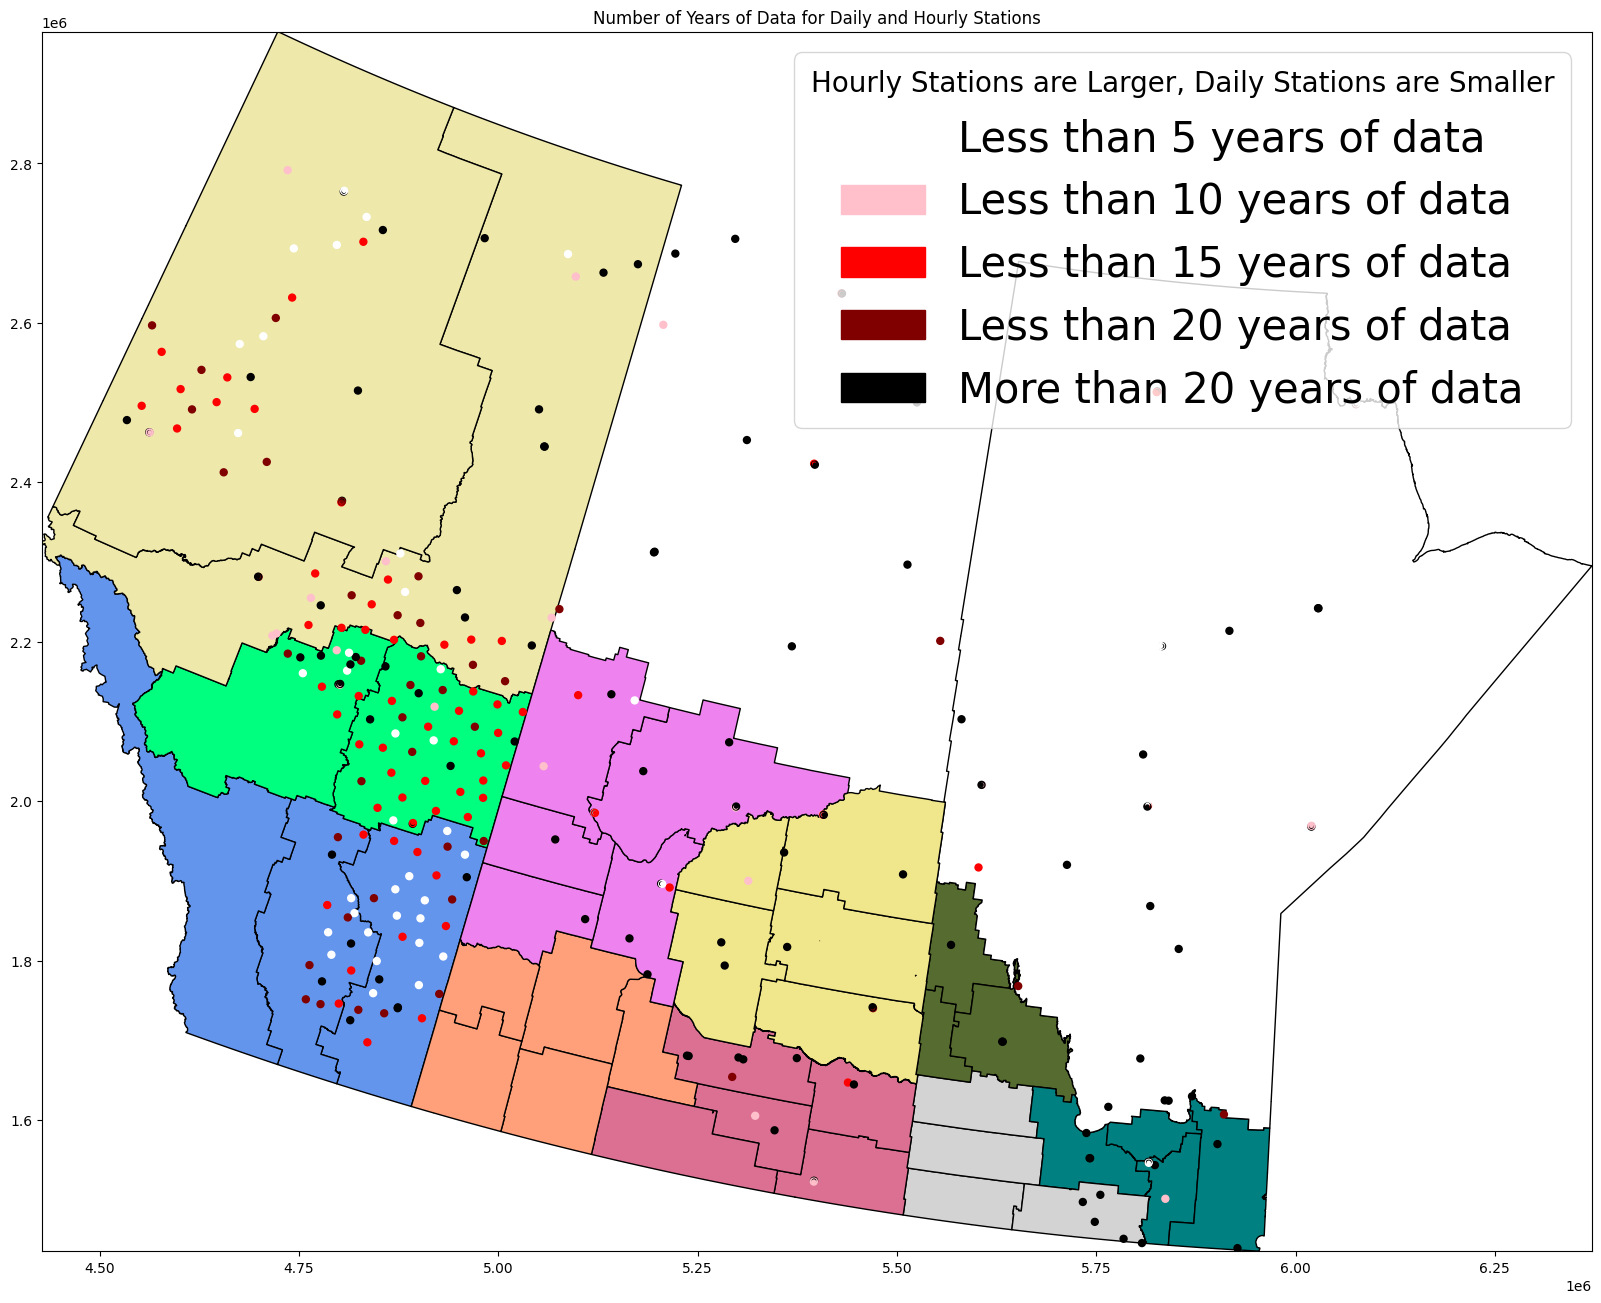

In [96]:
minx, miny, maxx, maxy = agRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("Number of Years of Data for Daily and Hourly Stations")
agRegions.plot(ax=ax, color=agRegions["color"], edgecolor="black")
coloredHlyStations.plot(ax=ax, color=coloredHlyStations["color"], markersize=25)
coloredDlyStations.plot(ax=ax, color=coloredDlyStations["color"], markersize=5)
plt.legend(
    title="Hourly Stations are Larger, Daily Stations are Smaller",
    title_fontsize="20",
    handles=[
        hasLessThan5Yrs,
        hasLessThan10Yrs,
        hasLessThan15Yrs,
        hasLessThan20Yrs,
        hasMoreThan20Yrs,
    ],
    fontsize="30",
)

In [101]:
def genReport(
    allHlyStations: gpd.GeoDataFrame,
    hlyStations: gpd.GeoDataFrame,
    coloredHlyStations: gpd.GeoDataFrame,
    activeHlyStations: gpd.GeoDataFrame,
    allDlyStations: gpd.GeoDataFrame,
    dlyStations: gpd.GeoDataFrame,
    coloredDlyStations: gpd.GeoDataFrame,
    activeDlyStations: gpd.GeoDataFrame,
    append: str = "",
):
    print(f"{append}Raw number of hourly stations: {len(allHlyStations.index)}")
    print(f"{append}Raw number of daily stations: {len(allDlyStations.index)}\n")

    print(
        f"{append}Number of hourly stations that satisfy elevation and have a unique position: {len(hlyStations.index)}"
    )
    print(
        f"{append}Number of daily stations that satisfy elevation and have a unique position: {len(dlyStations.index)}\n"
    )

    print(
        f"{append}The following statistics describe the restricted set of weather stations:"
    )
    print(
        f'\t{append}Number of hourly stations with at least 5 years of data: {len(coloredHlyStations[coloredHlyStations["color"] == hasLessThan5Col])}'
    )
    print(
        f'\t{append}Number of daily stations with at least 5 years of data: {len(coloredDlyStations[coloredDlyStations["color"] == hasLessThan5Col])}\n'
    )

    print(
        f'\t{append}Number of hourly stations with at least 10 years of data: {len(coloredHlyStations[coloredHlyStations["color"] == hasLessThan10Col])}'
    )
    print(
        f'\t{append}Number of daily stations with at least 10 years of data: {len(coloredDlyStations[coloredDlyStations["color"] == hasLessThan10Col])}\n'
    )

    print(
        f'\t{append}Number of hourly stations with at least 15 years of data: {len(coloredHlyStations[coloredHlyStations["color"] == hasLessThan15Col])}'
    )
    print(
        f'\t{append}Number of daily stations with at least 15 years of data: {len(coloredDlyStations[coloredDlyStations["color"] == hasLessThan15Col])}\n'
    )

    print(
        f'\t{append}Number of hourly stations with at least 20 years of data: {len(coloredHlyStations[coloredHlyStations["color"] == hasLessThan20Col])}'
    )
    print(
        f'\t{append}Number of daily stations with at least 20 years of data: {len(coloredDlyStations[coloredDlyStations["color"] == hasLessThan20Col])}\n'
    )

    print(
        f'\t{append}Number of hourly stations with more than 20 years of data: {len(coloredHlyStations[coloredHlyStations["color"] == hasMoreThan20Col])}'
    )
    print(
        f'\t{append}Number of daily stations with more than 20 years of data: {len(coloredDlyStations[coloredDlyStations["color"] == hasMoreThan20Col])}\n'
    )

    print(
        f"\t{append}Number of hourly stations that were active as of 2022: {len(activeHlyStations.index)}"
    )
    print(
        f"\t{append}Number of daily stations that were active as of 2022: {len(activeDlyStations.index)}\n"
    )

In [102]:
genReport(
    allHlyStations,
    hlyStations,
    coloredHlyStations,
    activeHlyStations,
    allDlyStations,
    dlyStations,
    coloredDlyStations,
    activeDlyStations,
)

Raw number of hourly stations: 472
Raw number of daily stations: 472

Number of hourly stations that satisfy elevation and have a unique position: 280
Number of daily stations that satisfy elevation and have a unique position: 280

The following statistics describe the restricted set of weather stations:
	Number of hourly stations with at least 5 years of data: 40
	Number of daily stations with at least 5 years of data: 40

	Number of hourly stations with at least 10 years of data: 24
	Number of daily stations with at least 10 years of data: 24

	Number of hourly stations with at least 15 years of data: 66
	Number of daily stations with at least 15 years of data: 66

	Number of hourly stations with at least 20 years of data: 42
	Number of daily stations with at least 20 years of data: 42

	Number of hourly stations with more than 20 years of data: 108
	Number of daily stations with more than 20 years of data: 108

	Number of hourly stations that were active as of 2022: 242
	Number of d

In [103]:
for index, row in agRegions.iterrows():
    currDistrict = row["car_uid"]
    province = "SK"

    if currDistrict < 4700:
        province = "MB"
    elif currDistrict >= 4800:
        province = "AB"

    allDistHlyStations = allHlyStations[allHlyStations["district"] == currDistrict]
    hlyDistStations = hlyStations[hlyStations["district"] == currDistrict]
    coloredDistHlyStations = coloredHlyStations[
        coloredHlyStations["district"] == currDistrict
    ]
    activeDistHlyStations = activeHlyStations[
        activeHlyStations["district"] == currDistrict
    ]
    allDistDlyStations = allDlyStations[allDlyStations["district"] == currDistrict]
    dlyDistStations = dlyStations[dlyStations["district"] == currDistrict]
    coloredDistDlyStations = coloredDlyStations[
        coloredDlyStations["district"] == currDistrict
    ]
    activeDistDlyStations = activeHlyStations[
        activeDlyStations["district"] == currDistrict
    ]

    print(f"District: {currDistrict} which is in {province}")
    genReport(
        allDistHlyStations,
        hlyDistStations,
        coloredDistHlyStations,
        activeDistHlyStations,
        allDistDlyStations,
        dlyDistStations,
        coloredDistDlyStations,
        activeDistDlyStations,
        "\t",
    )

    if len(hlyDistStations) > 0:
        print(
            f'\tHourly date range falls into: {int(hlyDistStations["min"].min())} - {int(hlyDistStations["max"].max())}'
        )
    if len(dlyDistStations) > 0:
        print(
            f'\tDaily date range falls into: {int(dlyDistStations["min"].min())} - {int(dlyDistStations["max"].max())}\n\n\n'
        )

District: 4601 which is in MB
	Raw number of hourly stations: 1
	Raw number of daily stations: 1

	Number of hourly stations that satisfy elevation and have a unique position: 0
	Number of daily stations that satisfy elevation and have a unique position: 0

	The following statistics describe the restricted set of weather stations:
		Number of hourly stations with at least 5 years of data: 0
		Number of daily stations with at least 5 years of data: 0

		Number of hourly stations with at least 10 years of data: 0
		Number of daily stations with at least 10 years of data: 0

		Number of hourly stations with at least 15 years of data: 0
		Number of daily stations with at least 15 years of data: 0

		Number of hourly stations with at least 20 years of data: 0
		Number of daily stations with at least 20 years of data: 0

		Number of hourly stations with more than 20 years of data: 0
		Number of daily stations with more than 20 years of data: 0

		Number of hourly stations that were active as